# Repeat Copy Task
### Differentiable Neural Computer (DNC) using a RNN Controller

<a href="http://www.nature.com/nature/journal/v538/n7626/full/nature20101.html"><img src="../static/dnc_schema.png" alt="DNC schema" style="width: 700px;"/></a>

**Sam Greydanus $\cdot$ February 2017 $\cdot$ MIT License.**

Represents the state of the art in differentiable memory. Inspired by this [Nature paper](http://www.nature.com/nature/journal/v538/n7626/full/nature20101.html). Some ideas taken from [this Gihub repo](https://github.com/Mostafa-Samir/DNC-tensorflow)

In [1]:
import tensorflow as tf
import numpy as np
import sys
sys.path.insert(0, '../dnc')

from dnc import DNC
from rnn_controller import RNNController

import matplotlib.pyplot as plt
%matplotlib inline

### Hyperparameters

In [2]:
xydim = 6
tf.app.flags.DEFINE_integer("xlen", xydim, "Input dimension")
tf.app.flags.DEFINE_integer("ylen", xydim, "output dimension")
tf.app.flags.DEFINE_integer("length", 5, "Sequence length")
tf.app.flags.DEFINE_integer("reps", 3, "Number of repeats for copy task")
tf.app.flags.DEFINE_integer("batch_size", 1, "Size of batch in minibatch gradient descent")

tf.app.flags.DEFINE_integer("R", 1, "Number of DNC read heads")
tf.app.flags.DEFINE_integer("W", 10, "Word length for DNC memory")
tf.app.flags.DEFINE_integer("N", 7, "Number of words the DNC memory can store")

tf.app.flags.DEFINE_integer("print_every", 100, "Print training info after this number of train steps")
tf.app.flags.DEFINE_integer("iterations", 10000, "Number of training iterations")
tf.app.flags.DEFINE_float("lr", 1e-4, "Learning rate (alpha) for the model")
tf.app.flags.DEFINE_float("momentum", .9, "RMSProp momentum")
tf.app.flags.DEFINE_integer("save_every", 1000, "Save model after this number of train steps")
tf.app.flags.DEFINE_string("save_path", "rnn_models/model.ckpt", "Where to save checkpoints")
FLAGS = tf.app.flags.FLAGS

### Data functions

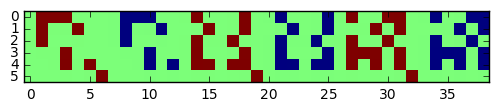

In [3]:
def get_sequence(length, reps, dim):
    X = [np.concatenate((np.random.randint(2, size=(length,dim)), np.zeros((length + 3,dim)))) for _ in range(reps)]
    X = np.vstack(X) ; X[:,dim-1] = 0
    
    X = np.concatenate((X[-1:,:],X[:-1,:]))
    y = np.concatenate((X[-(length + 2):,:],X[:-(length + 2),:]))
    markers = range(length+1, X.shape[0], 2*length+3)
    X[markers,dim-1] = 1
    return X, y
        
def next_batch(batch_size, length, reps, dim):
    X_batch = []
    y_batch = []
    for _ in range(batch_size):
        X, y = get_sequence(length, reps, dim)
        X_batch.append(X) ; y_batch.append(y)
    return [X_batch, y_batch]

batch = next_batch(1, FLAGS.length, FLAGS.reps, FLAGS.xlen)
plt.imshow(batch[0][0].T - batch[1][0].T, interpolation='none')
plt.show()

### Helper functions

In [4]:
def binary_cross_entropy(y_hat, y):
    return tf.reduce_mean(-y*tf.log(y_hat) - (1-y)*tf.log(1-y_hat))

def llprint(message):
    sys.stdout.write(message)
    sys.stdout.flush()

### Build graph, initialize everything

In [5]:
sess = tf.InteractiveSession()

llprint("building graph...\n")
optimizer = tf.train.RMSPropOptimizer(FLAGS.lr, momentum=FLAGS.momentum)
dnc = DNC(RNNController, FLAGS)

llprint("defining loss...\n")
y_hat, outputs = dnc.get_outputs()
y_hat = tf.clip_by_value(tf.sigmoid(y_hat), 1e-6, 1. - 1e-6)
loss = binary_cross_entropy(y_hat, dnc.y)

llprint("computing gradients...\n")
gradients = optimizer.compute_gradients(loss)
for i, (grad, var) in enumerate(gradients):
    if grad is not None:
        gradients[i] = (tf.clip_by_value(grad, -10, 10), var)
                    
grad_op = optimizer.apply_gradients(gradients)

llprint("init variables... \n")
sess.run(tf.global_variables_initializer())
llprint("ready to train...")

building graph...
defining loss...
computing gradients...
init variables... 
ready to train...

In [6]:
# tf parameter overview
total_parameters = 0 ; print "model overview..."
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print '\tvariable "{}" has {} parameters' \
        .format(variable.name, variable_parameters)
    total_parameters += variable_parameters
print "total of {} parameters".format(total_parameters)

model overview...
	variable "basic_lstm_cell/weights:0" has 20480 parameters
	variable "basic_lstm_cell/biases:0" has 256 parameters
	variable "W_z:0" has 3072 parameters
	variable "W_v:0" has 384 parameters
	variable "W_r:0" has 60 parameters
	variable "while_loop/basic_lstm_cell/weights:0" has 20480 parameters
	variable "while_loop/basic_lstm_cell/biases:0" has 256 parameters
total of 44988 parameters


In [7]:
global_step = 0
saver = tf.train.Saver(tf.global_variables())
load_was_success = True # yes, I'm being optimistic
try:
    save_dir = '/'.join(FLAGS.save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(sess, load_path)
except:
    print "no saved model to load."
    load_was_success = False
else:
    print "loaded model: {}".format(load_path)
    saver = tf.train.Saver(tf.global_variables())
    global_step = int(load_path.split('-')[-1]) + 1

loaded model: rnn_models/model.ckpt-7000


### Train loop

In [8]:
loss_history = []
for i in xrange(global_step, FLAGS.iterations + 1):
    llprint("\rIteration {}/{}".format(i, FLAGS.iterations))

    rlen = np.random.randint(1, FLAGS.length + 1)
    rreps = np.random.randint(1, FLAGS.reps + 1)
    X, y = next_batch(FLAGS.batch_size, rlen, rreps, FLAGS.xlen)
    tsteps = rreps*(2*rlen+3)

    fetch = [loss, grad_op]
    feed = {dnc.X: X, dnc.y: y, dnc.tsteps: tsteps}

    step_loss, _ = sess.run(fetch, feed_dict=feed)
    loss_history.append(step_loss)
    global_step = i

    if i % 100 == 0:
        llprint("\n\tloss: {:03.4f}\n".format(np.mean(loss_history)))
        loss_history = []
    if i % FLAGS.save_every == 0 and i is not 0:
        llprint("\n\tSAVING MODEL\n")
        saver.save(sess, FLAGS.save_path, global_step=global_step)

Iteration 7100/10000
	loss: 0.0758
Iteration 7200/10000
	loss: 0.0761
Iteration 7300/10000
	loss: 0.0640
Iteration 7400/10000
	loss: 0.0725
Iteration 7500/10000
	loss: 0.0759
Iteration 7600/10000
	loss: 0.0738
Iteration 7700/10000
	loss: 0.0689
Iteration 7800/10000
	loss: 0.0702
Iteration 7900/10000
	loss: 0.0741
Iteration 7978/10000

KeyboardInterrupt: 

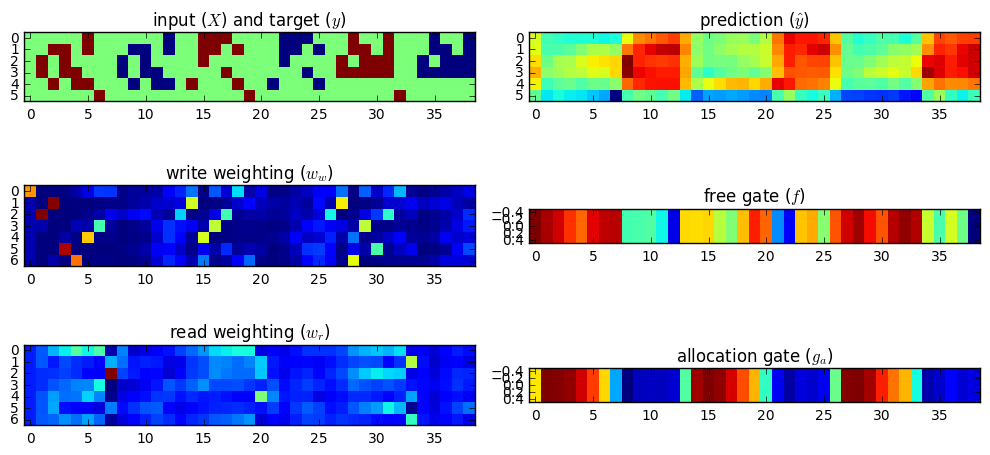

In [9]:
X, y = next_batch(FLAGS.batch_size, FLAGS.length, FLAGS.reps, FLAGS.xlen)
tsteps = FLAGS.reps*(2*FLAGS.length+3)

feed = {dnc.X: X, dnc.y: y, dnc.tsteps: tsteps}
fetch = [outputs['y_hat'], outputs['w_w'], outputs['w_r'], outputs['f'], outputs['g_a']]
[_y_hat, _w_w, _w_r, _f, _g_a] = sess.run(fetch, feed)
_y = y[0] ; _X = X[0]

fig, ((ax1,ax2),(ax3,ax5),(ax4,ax6),) = plt.subplots(nrows=3, ncols=2)
plt.rcParams['savefig.facecolor'] = "0.8"
fs = 12 # font size
fig.set_figwidth(10)
fig.set_figheight(5)

ax1.imshow(_X.T - _y.T, interpolation='none') ; ax1.set_title('input ($X$) and target ($y$)')
ax2.imshow(_y_hat[0,:,:].T, interpolation='none') ; ax2.set_title('prediction ($\hat y$)')

ax3.imshow(_w_w[0,:,:].T, interpolation='none') ; ax3.set_title('write weighting ($w_w$)')
ax4.imshow(_w_r[0,:,:,0].T, interpolation='none') ; ax4.set_title('read weighting ($w_r$)')

ax5.imshow(_f[0,:,:].T, interpolation='none') ; ax5.set_title('free gate ($f$)') ; ax5.set_aspect(3)
ax6.imshow(_g_a[0,:,:].T, interpolation='none') ; ax6.set_title('allocation gate ($g_a$)') ; ax6.set_aspect(3)

plt.tight_layout()